In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SAMPLE_RATE = 22050
N_MFCC = 80
BATCH_SIZE = 60
LEARNING_RATE = 0.02
EPOCHS = 750

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
DATASET_PATH = "C:/Users/NJS/Desktop/Thesis/RAVDESS_DATASET"

In [5]:
def extract_mfcc_sequence(waveform):
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mfcc_transform = T.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        melkwargs={'n_fft': 2048, 'hop_length': 512, 'n_mels': 128}
    )
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.squeeze(0).transpose(0, 1)
    return mfcc

In [6]:
def extract_prosodic_features(waveform, sample_rate=SAMPLE_RATE):
    pitch = torchaudio.functional.detect_pitch_frequency(waveform, sample_rate)
    pitch = pitch[pitch > 0]  # filter out zeros
    if pitch.numel() == 0:
        pitch_mean, pitch_std = 0.0, 0.0
    else:
        pitch_mean, pitch_std = pitch.mean().item(), pitch.std().item()
    energy = waveform.pow(2).mean().sqrt().item()
    return torch.tensor([pitch_mean, pitch_std, energy], dtype=torch.float32)

In [7]:
def pad_sequence(sequences):
    lengths = [s.shape[0] for s in sequences]
    max_len = max(lengths)
    padded = torch.zeros(len(sequences), max_len, sequences[0].shape[1])
    for i, seq in enumerate(sequences):
        end = lengths[i]
        if isinstance(seq, torch.Tensor):
            padded[i, :end, :] = seq.detach().clone()
        else:
            padded[i, :end, :] = torch.tensor(seq, dtype=torch.float32)
    return padded

In [8]:
def load_dataset(path):
    files = []
    labels = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith(".wav"):
                full_path = os.path.join(dirname, filename)
                emotion = os.path.basename(dirname).lower()
                files.append(full_path)
                labels.append(emotion)
    df = pd.DataFrame({'path': files, 'label': labels})
    return df

In [9]:
class SERDataset(Dataset):
    def __init__(self, dataframe, label_encoder, scaler, prosodic_scaler):
        self.paths = dataframe['path'].values
        self.labels = label_encoder.transform(dataframe['label'].values)
        self.scaler = scaler
        self.prosodic_scaler = prosodic_scaler

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.paths[idx])
        if sr != SAMPLE_RATE:
            resample = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
            waveform = resample(waveform)
        mfcc = extract_mfcc_sequence(waveform)
        prosodic = extract_prosodic_features(waveform)
        mfcc = self.scaler.transform(mfcc.cpu().numpy())
        prosodic = prosodic_scaler.transform(prosodic.unsqueeze(0).numpy()).squeeze(0)
        prosodic = torch.tensor(prosodic, dtype=torch.float32)
        return torch.tensor(mfcc, dtype=torch.float32), prosodic, torch.tensor(self.labels[idx], dtype=torch.long)

In [10]:
def collate_fn(batch):
    sequences, prosodics, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences)
    prosodics = torch.stack(prosodics).float()
    labels = torch.stack(labels)
    return sequences_padded, prosodics, labels

In [11]:
class AttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        weights = self.attention(x)
        weights = torch.softmax(weights, dim=1)
        return (x * weights).sum(dim=1)

In [12]:
class HybridLSTMTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=N_MFCC, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=1024, dropout=0.3, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.attn_pool = AttentionPooling(256)
        self.fc = nn.Sequential(
            nn.Linear(256 + 3, 256),  # input size matches BiLSTM+prosodic
            nn.ReLU(),
            nn.Linear(256, 64),  # fix shape mismatch
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, prosodic):
        lstm_out, _ = self.lstm(x)
        trans_out = self.transformer(lstm_out)
        pooled = self.attn_pool(trans_out)
        fused = torch.cat([pooled, prosodic], dim=1)
        return self.fc(fused)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience=10):
    best_acc = 0
    all_preds = []
    all_labels = []
    train_losses, val_accuracies = [], []

    best_acc = 0
    best_epoch = 0
    no_improve_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for x, p, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            
            x, p, y = x.to(device), p.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, p)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        all_preds.clear()
        all_labels.clear()
        with torch.no_grad():
            for x, p, y in val_loader:
                x, p, y = x.to(device), p.to(device), y.to(device)
                output = model(x, p)
                preds = output.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
                correct += (preds == y).sum().item()
                total += y.size(0)
        acc = correct / total
        val_accuracies.append(acc)

        print(f"Epoch {epoch+1}: Train Loss = {running_loss:.4f}, Val Acc = {acc*100:.2f}%")
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch
            no_improve_counter = 0
            torch.save(model.state_dict(), "best_hybrid_model.pth")
            print("Model saved.")
        else:
            no_improve_counter += 1

        scheduler.step(acc)

        if no_improve_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best epoch was {best_epoch+1}.")
            break

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/750: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]


Epoch 1: Train Loss = 40.8812, Val Acc = 16.30%
Model saved.


Epoch 2/750: 100%|██████████| 21/21 [00:45<00:00,  2.17s/it]


Epoch 2: Train Loss = 39.7151, Val Acc = 28.15%
Model saved.


Epoch 3/750: 100%|██████████| 21/21 [00:45<00:00,  2.19s/it]


Epoch 3: Train Loss = 38.3446, Val Acc = 22.96%


Epoch 4/750: 100%|██████████| 21/21 [00:47<00:00,  2.27s/it]


Epoch 4: Train Loss = 36.2051, Val Acc = 37.04%
Model saved.


Epoch 5/750: 100%|██████████| 21/21 [00:47<00:00,  2.28s/it]


Epoch 5: Train Loss = 33.7848, Val Acc = 36.30%


Epoch 6/750: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Epoch 6: Train Loss = 32.9233, Val Acc = 37.04%


Epoch 7/750: 100%|██████████| 21/21 [00:48<00:00,  2.33s/it]


Epoch 7: Train Loss = 32.4484, Val Acc = 42.96%
Model saved.


Epoch 8/750: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Epoch 8: Train Loss = 30.4382, Val Acc = 45.19%
Model saved.


Epoch 9/750: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 9: Train Loss = 28.7675, Val Acc = 44.44%


Epoch 10/750: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Epoch 10: Train Loss = 26.3105, Val Acc = 47.41%
Model saved.


Epoch 11/750: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 11: Train Loss = 27.4988, Val Acc = 50.37%
Model saved.


Epoch 12/750: 100%|██████████| 21/21 [00:47<00:00,  2.24s/it]


Epoch 12: Train Loss = 26.7539, Val Acc = 48.15%


Epoch 13/750: 100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Epoch 13: Train Loss = 23.5878, Val Acc = 48.15%


Epoch 14/750: 100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Epoch 14: Train Loss = 24.0412, Val Acc = 55.56%
Model saved.


Epoch 15/750: 100%|██████████| 21/21 [00:49<00:00,  2.36s/it]


Epoch 15: Train Loss = 21.9085, Val Acc = 46.67%


Epoch 16/750: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


Epoch 16: Train Loss = 26.7851, Val Acc = 43.70%


Epoch 17/750: 100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Epoch 17: Train Loss = 22.2673, Val Acc = 53.33%


Epoch 18/750: 100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Epoch 18: Train Loss = 19.4050, Val Acc = 57.78%
Model saved.


Epoch 19/750: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Epoch 19: Train Loss = 16.6324, Val Acc = 56.30%


Epoch 20/750: 100%|██████████| 21/21 [00:46<00:00,  2.20s/it]


Epoch 20: Train Loss = 14.7460, Val Acc = 54.07%


Epoch 21/750: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 21: Train Loss = 14.6343, Val Acc = 58.52%
Model saved.


Epoch 22/750: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 22: Train Loss = 20.9168, Val Acc = 64.44%
Model saved.


Epoch 23/750: 100%|██████████| 21/21 [00:47<00:00,  2.28s/it]


Epoch 23: Train Loss = 13.9050, Val Acc = 56.30%


Epoch 24/750: 100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Epoch 24: Train Loss = 14.2261, Val Acc = 62.96%


Epoch 25/750: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Epoch 25: Train Loss = 13.0603, Val Acc = 65.19%
Model saved.


Epoch 26/750: 100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


Epoch 26: Train Loss = 11.6866, Val Acc = 65.93%
Model saved.


Epoch 27/750: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Epoch 27: Train Loss = 9.5368, Val Acc = 66.67%
Model saved.


Epoch 28/750: 100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Epoch 28: Train Loss = 7.8116, Val Acc = 68.15%
Model saved.


Epoch 29/750: 100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Epoch 29: Train Loss = 14.4068, Val Acc = 62.96%


Epoch 30/750: 100%|██████████| 21/21 [00:46<00:00,  2.21s/it]


Epoch 30: Train Loss = 9.6348, Val Acc = 63.70%


Epoch 31/750: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it]


Epoch 31: Train Loss = 6.3520, Val Acc = 62.22%


Epoch 32/750: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


Epoch 32: Train Loss = 9.0977, Val Acc = 57.78%


Epoch 33/750: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


Epoch 33: Train Loss = 6.3970, Val Acc = 62.96%


Epoch 34/750: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 34: Train Loss = 10.1947, Val Acc = 67.41%


Epoch 35/750: 100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


Epoch 35: Train Loss = 3.5656, Val Acc = 74.81%
Model saved.


Epoch 36/750: 100%|██████████| 21/21 [00:48<00:00,  2.33s/it]


Epoch 36: Train Loss = 3.8807, Val Acc = 71.85%


Epoch 37/750: 100%|██████████| 21/21 [00:49<00:00,  2.33s/it]


Epoch 37: Train Loss = 2.5422, Val Acc = 71.85%


Epoch 38/750: 100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


Epoch 38: Train Loss = 1.0473, Val Acc = 70.37%


Epoch 39/750: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Epoch 39: Train Loss = 0.5767, Val Acc = 71.11%


Epoch 40/750: 100%|██████████| 21/21 [00:47<00:00,  2.24s/it]


Epoch 40: Train Loss = 0.3763, Val Acc = 74.81%


Epoch 41/750: 100%|██████████| 21/21 [00:46<00:00,  2.24s/it]


Epoch 41: Train Loss = 0.4595, Val Acc = 74.81%


Epoch 42/750: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Epoch 42: Train Loss = 0.2660, Val Acc = 78.52%
Model saved.


Epoch 43/750: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 43: Train Loss = 0.1221, Val Acc = 79.26%
Model saved.


Epoch 44/750: 100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Epoch 44: Train Loss = 0.0828, Val Acc = 77.78%


Epoch 45/750: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it]


Epoch 45: Train Loss = 0.0880, Val Acc = 78.52%


Epoch 46/750: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


Epoch 46: Train Loss = 0.0668, Val Acc = 79.26%


Epoch 47/750: 100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


Epoch 47: Train Loss = 0.1008, Val Acc = 79.26%


Epoch 48/750: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Epoch 48: Train Loss = 0.0865, Val Acc = 75.56%


Epoch 49/750: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it]


Epoch 49: Train Loss = 0.0830, Val Acc = 77.04%


Epoch 50/750: 100%|██████████| 21/21 [00:50<00:00,  2.38s/it]


Epoch 50: Train Loss = 0.0560, Val Acc = 77.78%


Epoch 51/750: 100%|██████████| 21/21 [00:48<00:00,  2.33s/it]


Epoch 51: Train Loss = 0.0824, Val Acc = 77.78%


Epoch 52/750: 100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Epoch 52: Train Loss = 0.0580, Val Acc = 79.26%


Epoch 53/750: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


Epoch 53: Train Loss = 0.0553, Val Acc = 79.26%
Early stopping triggered at epoch 53. Best epoch was 43.


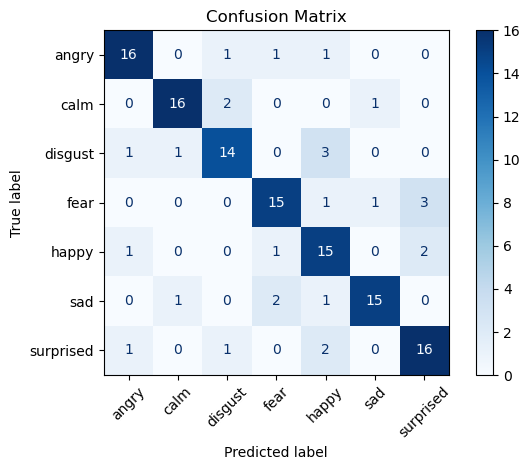

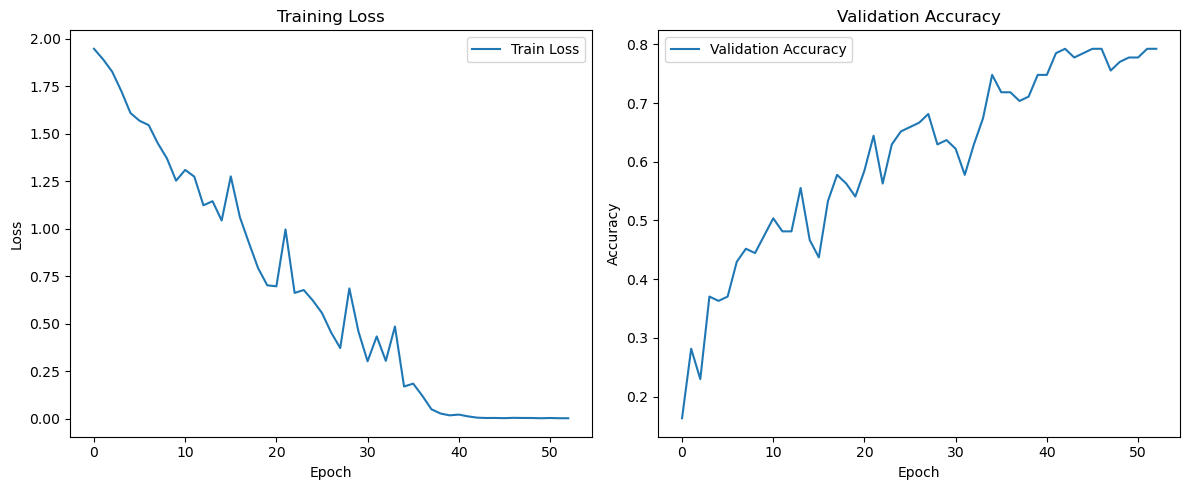

In [14]:
df = load_dataset(DATASET_PATH)
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])


# Fit scalers on training data
all_mfcc = []
all_prosodic = []
for path in train_df['path']:
    waveform, sr = torchaudio.load(path)
    if sr != SAMPLE_RATE:
        waveform = T.Resample(sr, SAMPLE_RATE)(waveform)
    mfcc = extract_mfcc_sequence(waveform)
    prosodic = extract_prosodic_features(waveform)
    all_mfcc.append(mfcc.cpu().numpy())
    all_prosodic.append(prosodic.numpy())
all_mfcc_flat = np.concatenate([m for m in all_mfcc], axis=0)
scaler = StandardScaler().fit(all_mfcc_flat)
prosodic_scaler = StandardScaler().fit(np.stack(all_prosodic))

train_dataset = SERDataset(train_df, label_encoder, scaler, prosodic_scaler)
val_dataset = SERDataset(val_df, label_encoder, scaler, prosodic_scaler)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = HybridLSTMTransformer(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

train_model(model, train_loader, val_loader, criterion, optimizer)

In [15]:
from sklearn.metrics import classification_report

# Get predictions and true labels for the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, p, y in val_loader:
        x, p = x.to(device), p.to(device)
        outputs = model(x, p)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.84      0.84      0.84        19
        calm       0.89      0.84      0.86        19
     disgust       0.78      0.74      0.76        19
        fear       0.79      0.75      0.77        20
       happy       0.65      0.79      0.71        19
         sad       0.88      0.79      0.83        19
   surprised       0.76      0.80      0.78        20

    accuracy                           0.79       135
   macro avg       0.80      0.79      0.79       135
weighted avg       0.80      0.79      0.79       135

